In [1]:
import torch
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
import os
import CNNImageClassifier
from data_loader import get_dataloaders
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [2]:
data_dir = '../data/final/'
split_dir = '../splits/'
batch_size = 32

# Load the test set
_, _, test_loader = get_dataloaders(data_dir, label_path=os.path.join(data_dir, 'labels.pt'), split_dir=split_dir, batch_size=batch_size)

c:\classifier\src\data_loader.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.labels = torch.load(label_path)  # Load the .pt file with labels


In [4]:
# Function to load all models and dynamically set arguments based on the model_name
def load_all_models(model_dir, device):
    models = {}
    
    # Regex pattern to extract layer_count, filter_size, kernel, pool, and lr from model_name
    pattern = re.compile(r'([A-Za-z]+)_L(\d+)_F(\d+)_K(\d+)_P(\d+)_lr([\de\.-]+)')
    
    for model_name in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_name, 'model.pth')
        if os.path.exists(model_path):
            # Parse the model_name to extract the hyperparameters
            match = pattern.match(model_name)
            if match:
                model_type = match.group(1)
                layer_count = int(match.group(2))
                filter_size = int(match.group(3))
                kernel = int(match.group(4))
                pool = int(match.group(5))
                lr = float(match.group(6))

                # Dynamically instantiate the model using the parsed values
                model = CNNImageClassifier.CNNImageClassifier(
                    input_size=(3, 256, 256), num_classes=4, num_filters=filter_size, 
                    kernel_size=kernel, pool_size=pool, num_layers=layer_count, fc_size=512
                ).to(device)
                
                # Load the state_dict (weights) from the checkpoint
                checkpoint = torch.load(model_path)
                model.load_state_dict(checkpoint['state_dict'])
                model.eval()

                # Store the model with its corresponding name
                models[model_name] = model
    
    return models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_dir = '../models/'

# Load all models
models = load_all_models(model_dir, device)

# Check loaded models
print(f"Loaded models: {list(models.keys())}")

C:\Users\waqaa\AppData\Local\Temp\ipykernel_13016\2409939469.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded models: ['CNN_L3_F32_K3_P2_lr0.0001', 'CNN_L3_F32_K5_P2_lr0.0001', 'CNN_L3_F32_K7_P2_lr0.0001', 'CNN_L3_F64_K3_P2_lr0.0001', 'CNN_L3_F64_K5_P2_lr0.0001', 'CNN_L3_F64_K7_P2_lr0.0001', 'CNN_L5_F32_K3_P2_lr0.0001', 'CNN_L5_F32_K5_P2_lr0.0001', 'CNN_L5_F32_K7_P2_lr0.0001', 'CNN_L5_F64_K3_P2_lr0.0001', 'CNN_L5_F64_K5_P2_lr0.0001', 'CNN_L5_F64_K7_P2_lr0.0001']


In [58]:
def evaluate_all_models(models, test_loader, device):
    model_results = {}

    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")
        all_preds = []
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for imgs, labels in tqdm(test_loader):
                imgs = imgs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(imgs)
                probs = F.softmax(outputs, dim=1)  # Get probabilities using softmax
                preds = probs.argmax(dim=1)        # Predicted class labels

                # Convert one-hot labels to class indices
                if labels.ndim > 1:  # if labels are one-hot encoded
                    labels = labels.argmax(dim=1)

                # predictions, probabilities, and labels
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Store predictions, probabilities, and labels for each model
        model_results[model_name] = {
            'preds': np.array(all_preds),
            'probs': np.array(all_probs),
            'labels': np.array(all_labels)
        }
    
    return model_results

# Get predictions, probabilities, and true labels for all models
model_results = evaluate_all_models(models, test_loader, device)

Evaluating model: CNN_L3_F32_K3_P2_lr0.0001


100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


Evaluating model: CNN_L3_F32_K5_P2_lr0.0001


100%|██████████| 7/7 [00:22<00:00,  3.18s/it]


Evaluating model: CNN_L3_F32_K7_P2_lr0.0001


100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Evaluating model: CNN_L3_F64_K3_P2_lr0.0001


100%|██████████| 7/7 [00:30<00:00,  4.30s/it]


Evaluating model: CNN_L3_F64_K5_P2_lr0.0001


100%|██████████| 7/7 [00:22<00:00,  3.29s/it]


Evaluating model: CNN_L3_F64_K7_P2_lr0.0001


100%|██████████| 7/7 [00:21<00:00,  3.12s/it]


Evaluating model: CNN_L5_F32_K3_P2_lr0.0001


100%|██████████| 7/7 [00:19<00:00,  2.78s/it]


Evaluating model: CNN_L5_F32_K5_P2_lr0.0001


100%|██████████| 7/7 [00:20<00:00,  2.87s/it]


Evaluating model: CNN_L5_F32_K7_P2_lr0.0001


100%|██████████| 7/7 [00:22<00:00,  3.28s/it]


Evaluating model: CNN_L5_F64_K3_P2_lr0.0001


100%|██████████| 7/7 [00:24<00:00,  3.48s/it]


Evaluating model: CNN_L5_F64_K5_P2_lr0.0001


100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


Evaluating model: CNN_L5_F64_K7_P2_lr0.0001


100%|██████████| 7/7 [00:32<00:00,  4.71s/it]


In [43]:
# model_name cleaning function
def clean_model_name(model_name):
    # split by _ and drop the first and last element, then join the rest
    return '_'.join(model_name.split('_')[1:-2])

In [87]:
n_classes = 4

# color map with 12 distinct colors for the models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff9896', '#c49c94']

def calculate_roc_auc(model_results, n_classes):
    roc_data = {}

    for model_name, results in model_results.items():
        labels = results['labels']
        probs = results['probs']

        # Micro-average
        fpr_micro, tpr_micro, _ = roc_curve(label_binarize(labels, classes=np.arange(n_classes)).ravel(), probs.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)

        roc_data[model_name] = {
            'fpr_micro': fpr_micro,
            'tpr_micro': tpr_micro,
            'roc_auc_micro': roc_auc_micro
        }

    return roc_data

def calculate_prc_auc(model_results, n_classes):
    prc_data = {}

    for model_name, results in model_results.items():
        labels = results['labels']
        probs = results['probs']

        # Micro-average
        precision_micro, recall_micro, _ = precision_recall_curve(label_binarize(labels, classes=np.arange(n_classes)).ravel(), probs.ravel())
        prc_auc_micro = auc(recall_micro, precision_micro)

        prc_data[model_name] = {
            'precision_micro': precision_micro,
            'recall_micro': recall_micro,
            'prc_auc_micro': prc_auc_micro
        }

    return prc_data

# Calculate ROC and PRC AUCs for all models
roc_data = calculate_roc_auc(model_results, n_classes)
prc_data = calculate_prc_auc(model_results, n_classes)

# Create subplots with 1 row and 2 columns for side-by-side plots
fig = make_subplots(rows=1, cols=2, subplot_titles=("ROC Curve", "Precision-Recall Curve"))

# Plot ROC curve for each model in the first column, applying consistent colors
for idx, (model_name, roc) in enumerate(roc_data.items()):
    fig.add_trace(
        go.Scatter(x=roc['fpr_micro'], y=roc['tpr_micro'], mode='lines', name=clean_model_name(model_name),
                   line=dict(color=colors[idx % len(colors)]), showlegend=True),
        row=1, col=1
    )

# Plot PRC curve for each model in the second column, applying the same colors
for idx, (model_name, prc) in enumerate(prc_data.items()):
    fig.add_trace(
        go.Scatter(x=prc['recall_micro'], y=prc['precision_micro'], mode='lines', name=model_name,
                   line=dict(color=colors[idx % len(colors)]), showlegend=False),
        row=1, col=2
    )

# Update layout for the overall figure
fig.update_layout(
    title_text="ROC Curve and Precision-Recall Curve Side by Side",
    xaxis_title="False Positive Rate (ROC)",
    yaxis_title="True Positive Rate (ROC)",
    xaxis2_title="Recall (PRC)",
    yaxis2_title="Precision (PRC)"
)

fig.show()

In [88]:
best_model_roc = max(roc_data.items(), key=lambda x: x[1]['roc_auc_micro'])[0]
best_model_prc = max(prc_data.items(), key=lambda x: x[1]['prc_auc_micro'])[0]

print(f"Best model based on ROC AUC: {best_model_roc}")
print(f"Best model based on PR AUC: {best_model_prc}")

# print the ROC AUC for each model
for model_name, roc in roc_data.items():
    print(f"Model: {model_name}, ROC AUC: {roc['roc_auc_micro']:.4f}")

# print the PRC AUC for each model
for model_name, prc in prc_data.items():
    print(f"Model: {model_name}, PRC AUC: {prc['prc_auc_micro']:.4f}")

Best model based on ROC AUC: CNN_L5_F64_K5_P2_lr0.0001
Best model based on PR AUC: CNN_L5_F64_K5_P2_lr0.0001
Model: CNN_L3_F32_K3_P2_lr0.0001, ROC AUC: 0.8440
Model: CNN_L3_F32_K5_P2_lr0.0001, ROC AUC: 0.8987
Model: CNN_L3_F32_K7_P2_lr0.0001, ROC AUC: 0.8735
Model: CNN_L3_F64_K3_P2_lr0.0001, ROC AUC: 0.8673
Model: CNN_L3_F64_K5_P2_lr0.0001, ROC AUC: 0.8736
Model: CNN_L3_F64_K7_P2_lr0.0001, ROC AUC: 0.8931
Model: CNN_L5_F32_K3_P2_lr0.0001, ROC AUC: 0.8771
Model: CNN_L5_F32_K5_P2_lr0.0001, ROC AUC: 0.8286
Model: CNN_L5_F32_K7_P2_lr0.0001, ROC AUC: 0.8750
Model: CNN_L5_F64_K3_P2_lr0.0001, ROC AUC: 0.8934
Model: CNN_L5_F64_K5_P2_lr0.0001, ROC AUC: 0.9150
Model: CNN_L5_F64_K7_P2_lr0.0001, ROC AUC: 0.8971
Model: CNN_L3_F32_K3_P2_lr0.0001, PRC AUC: 0.6758
Model: CNN_L3_F32_K5_P2_lr0.0001, PRC AUC: 0.7805
Model: CNN_L3_F32_K7_P2_lr0.0001, PRC AUC: 0.7404
Model: CNN_L3_F64_K3_P2_lr0.0001, PRC AUC: 0.7310
Model: CNN_L3_F64_K5_P2_lr0.0001, PRC AUC: 0.7333
Model: CNN_L3_F64_K7_P2_lr0.0001, PRC AUC

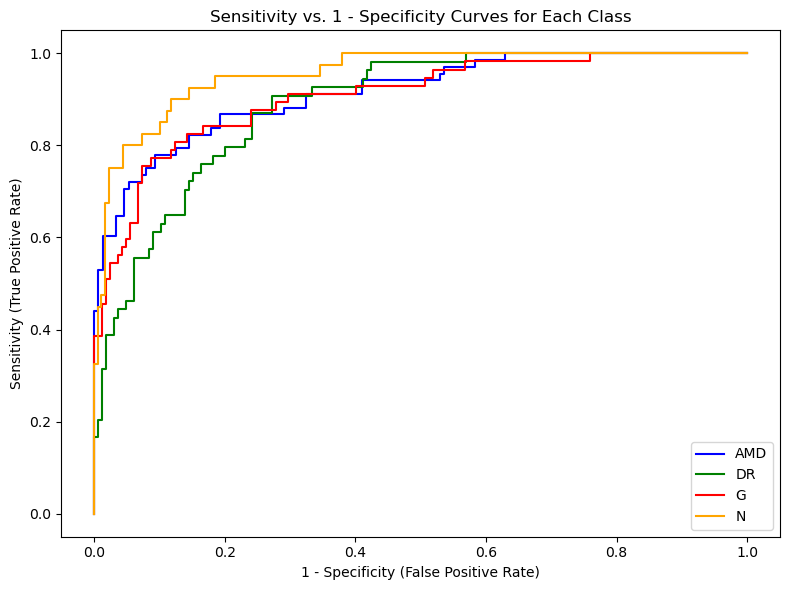

In [91]:
# Define the classes and their corresponding colors
classes = ['AMD', 'DR', 'G', 'N']
colors = ['blue', 'green', 'red', 'orange']

model_name = best_model_roc
results = model_results[model_name]

# true labels and predicted probabilities
labels = results['labels']
probs = results['probs']

# Create a figure
plt.figure(figsize=(8, 6))

# Plot ROC curves for each class
for i in range(n_classes):
    # Compute ROC curve for the current class
    fpr, tpr, _ = roc_curve(labels == i, probs[:, i])
    
    # Plot 1 - specificity (fpr) vs sensitivity (tpr) with specified color
    plt.plot(fpr, tpr, label=classes[i], color=colors[i])

# Set plot labels and title
plt.title("Sensitivity vs. 1 - Specificity Curves for Each Class")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [85]:
# Get true labels and probabilities for a model
model_name = best_model_roc
labels = model_results[model_name]['labels']
probs = model_results[model_name]['probs']

# Binarize the labels (one-vs-rest)
n_classes = probs.shape[1]
labels_bin = label_binarize(labels, classes=np.arange(n_classes))

# calculate Youden's J statistic for each class
best_thresholds = {}

for i in range(n_classes):
    # Compute ROC curve for classes in a ovr manner
    fpr, tpr, thresholds = roc_curve(labels_bin[:, i], probs[:, i])

    # Compute Youden's J statistic
    youden_j = tpr - fpr
    best_threshold_idx = np.argmax(youden_j)
    best_threshold = thresholds[best_threshold_idx]

    # Store the best threshold for this class
    best_thresholds[f"Class {i}"] = best_threshold

    print(f"Best threshold for {classes[i]} based on Youden's index: {best_threshold}")

print(best_thresholds)


Best threshold for AMD based on Youden's index: 0.5364924073219299
Best threshold for DR based on Youden's index: 0.07483498007059097
Best threshold for G based on Youden's index: 0.2304815798997879
Best threshold for N based on Youden's index: 0.3503756821155548
{'Class 0': 0.5364924, 'Class 1': 0.07483498, 'Class 2': 0.23048158, 'Class 3': 0.35037568}


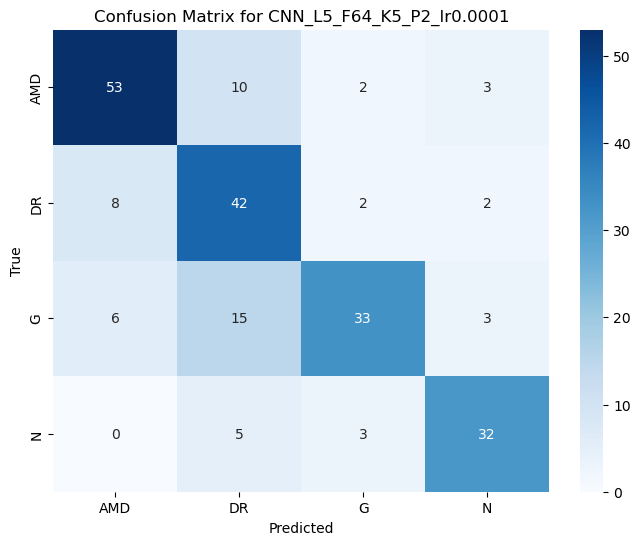

AMD: Sensitivity = 0.78, Specificity = 0.91
DR: Sensitivity = 0.78, Specificity = 0.82
G: Sensitivity = 0.58, Specificity = 0.96
N: Sensitivity = 0.80, Specificity = 0.96


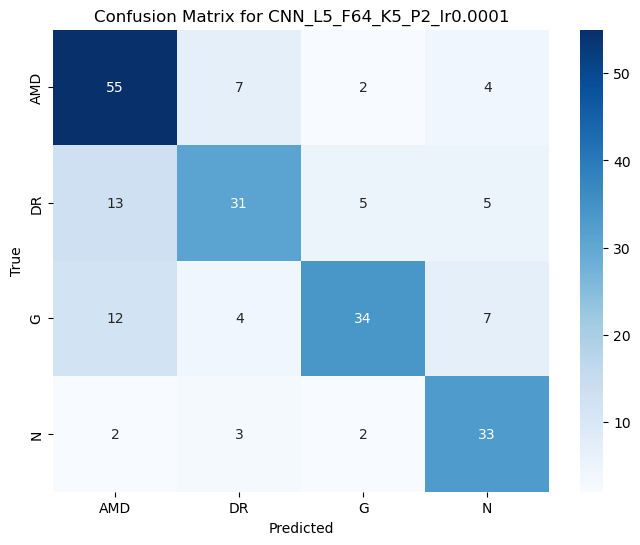

AMD: Sensitivity = 0.81, Specificity = 0.82
DR: Sensitivity = 0.57, Specificity = 0.92
G: Sensitivity = 0.60, Specificity = 0.94
N: Sensitivity = 0.82, Specificity = 0.91


In [81]:
# true labels and predicted probabilities
model_name = best_model_roc
labels = model_results[model_name]['labels']
probs = model_results[model_name]['probs']

# optimized thresholds for each class
thresholds = best_thresholds

# applying the thresholds to make predictions
preds = []
for prob in probs:
    class_preds = []
    for i in range(len(thresholds)):
        if prob[i] >= thresholds[f"Class {i}"]:
            class_preds.append(1)
        else:
            class_preds.append(0)
    preds.append(np.argmax(class_preds))

# confusion matrix
cm = confusion_matrix(labels, preds)

classes = ['AMD', 'DR', 'G', 'N']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[classes[i] for i in range(len(thresholds))], 
            yticklabels=[classes[i] for i in range(len(thresholds))])
plt.title(f"Confusion Matrix for {model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print out sensitivity and specificity
sensitivity = dict()
specificity = dict()

for i in range(n_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

for i in range(n_classes):
    print(f"{classes[i]}: Sensitivity = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}")

# repeat the process with default thresholds (0.5 for all classes)

model_name = best_model_roc
labels = model_results[model_name]['labels']
probs = model_results[model_name]['probs']

thresholds = {'Class 0': 0.5, 'Class 1': 0.5, 'Class 2': 0.5, 'Class 3': 0.5}

preds = []
for prob in probs:
    class_preds = []
    for i in range(len(thresholds)):
        if prob[i] >= thresholds[f"Class {i}"]:
            class_preds.append(1)
        else:
            class_preds.append(0)
    preds.append(np.argmax(class_preds))

cm = confusion_matrix(labels, preds)

classes = ['AMD', 'DR', 'G', 'N']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[classes[i] for i in range(len(thresholds))], 
            yticklabels=[classes[i] for i in range(len(thresholds))])
plt.title(f"Confusion Matrix for {model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

sensitivity = dict()
specificity = dict()

for i in range(n_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

for i in range(n_classes):
    print(f"{classes[i]}: Sensitivity = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}")

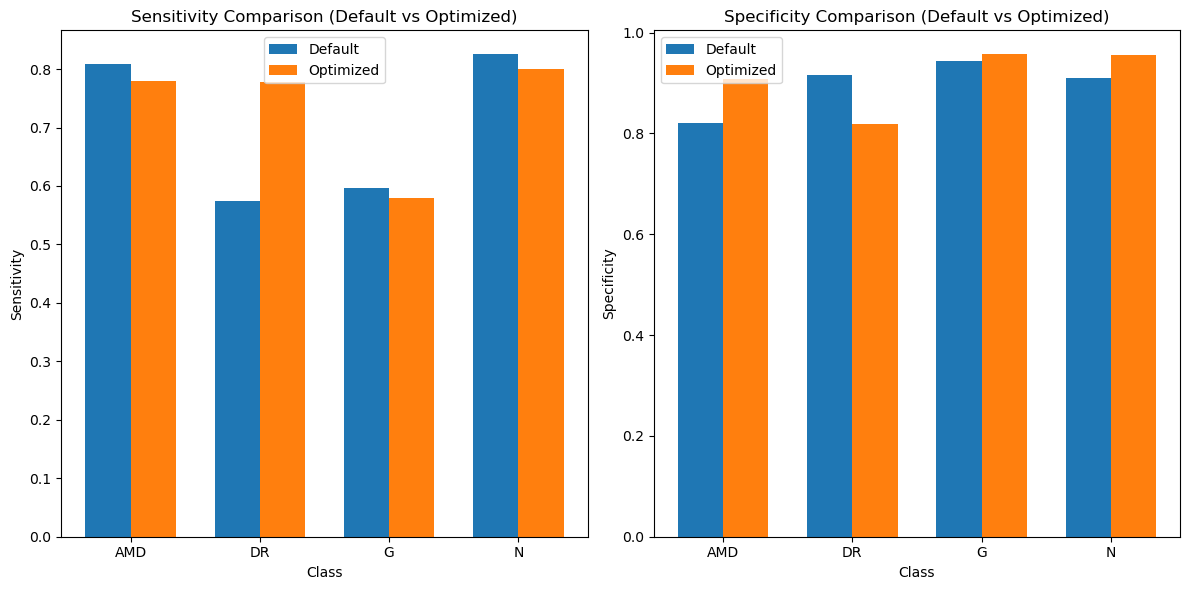

In [82]:
# Sensitivity and Specificity with default thresholds
sensitivity_default = {}
specificity_default = {}

# Sensitivity and Specificity with optimized thresholds
sensitivity_optimized = {}
specificity_optimized = {}

# Function to calculate sensitivity and specificity
def calculate_sensitivity_specificity(cm, n_classes):
    sensitivity = dict()
    specificity = dict()
    
    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (FP + FN + TP)
        
        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    return sensitivity, specificity

# true labels and predicted probabilities
model_name = best_model_roc
labels = model_results[model_name]['labels']
probs = model_results[model_name]['probs']

# Apply the default thresholds (0.5)
preds_default = []
thresholds_default = {'Class 0': 0.5, 'Class 1': 0.5, 'Class 2': 0.5, 'Class 3': 0.5}

for prob in probs:
    class_preds = []
    for i in range(len(thresholds_default)):
        if prob[i] >= thresholds_default[f"Class {i}"]:
            class_preds.append(1)
        else:
            class_preds.append(0)
    preds_default.append(np.argmax(class_preds))

# confusion matrix with default thresholds
cm_default = confusion_matrix(labels, preds_default)
sensitivity_default, specificity_default = calculate_sensitivity_specificity(cm_default, n_classes)

# Applying the optimized thresholds
preds_optimized = []
for prob in probs:
    class_preds = []
    for i in range(len(best_thresholds)):
        if prob[i] >= best_thresholds[f"Class {i}"]:
            class_preds.append(1)
        else:
            class_preds.append(0)
    preds_optimized.append(np.argmax(class_preds))

# confusion matrix with optimized thresholds
cm_optimized = confusion_matrix(labels, preds_optimized)
sensitivity_optimized, specificity_optimized = calculate_sensitivity_specificity(cm_optimized, n_classes)

# barplots for sensitivity and specificity
classes = ['AMD', 'DR', 'G', 'N']
x = np.arange(len(classes))  # Class labels as x-axis

# Bar width
bar_width = 0.35

# Create subplots for sensitivity and specificity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Sensitivity bar plot
ax1.bar(x - bar_width/2, [sensitivity_default[i] for i in range(n_classes)], bar_width, label='Default')
ax1.bar(x + bar_width/2, [sensitivity_optimized[i] for i in range(n_classes)], bar_width, label='Optimized')

ax1.set_xlabel('Class')
ax1.set_ylabel('Sensitivity')
ax1.set_title('Sensitivity Comparison (Default vs Optimized)')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.legend()

# Specificity bar plot
ax2.bar(x - bar_width/2, [specificity_default[i] for i in range(n_classes)], bar_width, label='Default')
ax2.bar(x + bar_width/2, [specificity_optimized[i] for i in range(n_classes)], bar_width, label='Optimized')

ax2.set_xlabel('Class')
ax2.set_ylabel('Specificity')
ax2.set_title('Specificity Comparison (Default vs Optimized)')
ax2.set_xticks(x)
ax2.set_xticklabels(classes)
ax2.legend()

plt.tight_layout()
plt.show()